# Provide Insights to the Chief of Operations in the Transportation Domain

**Company:** Goodcabs  
**Domain:** Transportation & Mobility  
**Function:** Operations  

Goodcabs is a cab service company that has been operating for two years, primarily serving tier-2 cities in India. Unlike other ride-sharing services, Goodcabs focuses on empowering local drivers by providing stable incomes while maintaining excellent service quality for passengers. The company operates in ten tier-2 cities and has set ambitious performance targets for 2024 to foster growth and boost customer satisfaction.

To evaluate its progress, Goodcabs’ management has identified several key performance indicators (KPIs):

- **Trip volume**  
- **Passenger satisfaction**  
- **Repeat passenger rate**  
- **Trip distribution**  
- **Ratio of new vs. returning passengers**

**Context:** Along with core (primary and secondary) analyses, there are several ad-hoc requests requiring data-driven insights. This Jupyter Notebook addresses those ad-hoc requests, aiming to provide actionable recommendations for Goodcabs.

*This project is part of the **Codebasics Resume Project Challenge #13.** You can learn more about the problem statement, dataset, and other details in the **GitHub README file.***


In [158]:
#let us import the necessary libraries first

from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [344]:
# Now connecting to the MYSSQL databse hosted in my personal windows machine using SQLAlchemy

engine = create_engine(
    "mysql+pymysql://remote_user@10.0.0.65:3306/trips_db",
    connect_args={"password": "Loke@1011"}
)

# Running a simple query to make sure connection is successfull and Load Data into Pandas

query = "SELECT * FROM dim_city;"
df = pd.read_sql(query, engine)

# Display the DataFrame
df.head(10)

,city_id,city_name
0,AP01,Visakhapatnam
1,CH01,Chandigarh
2,GJ01,Surat
3,GJ02,Vadodara
4,KA01,Mysore
5,KL01,Kochi
6,MP01,Indore
7,RJ01,Jaipur
8,TN01,Coimbatore
9,UP01,Lucknow


# **Business Request - 1**: City-Level Fare and Trip Summary Report

Generate a report that displays the total trips, average fare per km, average fare per trip, and the percentage contribution of each city’s trips to the overall trips. This report will help in assessing trip volume, pricing efficiency, and each city’s contribution to the overall trip count.

### **Fields:**
- `city_name`
- `total_trips`
- `avg_fare_per_km`
- `avg_fare_per_trip`
- `%_contribution_to_total_trips`

In [32]:
# Generating a report as per Business Request - 1

query = '''
WITH cte AS (
	SELECT
		city_name, 
		COUNT(trip_id) AS no_of_trips,
		SUM(fare_amount)/SUM(distance_travelled_km) AS avg_fare_per_km,
		AVG(fare_amount) AS avg_fare_per_trip
	FROM
		fact_trips
	JOIN
		dim_city
	USING 
		(city_id)
	GROUP BY
		city_name
)
SELECT 
	*,
    ROUND(no_of_trips*100 / SUM(no_of_trips) over(),2) AS pct_contribution_to_total_trips 
FROM cte
'''
df_adhoc_1 = pd.read_sql(query, engine)

df_adhoc_1

,city_name,no_of_trips,avg_fare_per_km,avg_fare_per_trip,pct_contribution_to_total_trips
0,Chandigarh,38981,12.0622,283.6870,9.15
1,Coimbatore,21104,11.1476,166.9822,4.96
2,Indore,42456,10.8977,179.8386,9.97
3,Jaipur,76888,16.1182,483.9181,18.05
4,Kochi,50702,13.9305,335.2451,11.90
5,Lucknow,64299,11.7622,147.1804,15.10
6,Mysore,16238,15.1366,249.7072,3.81
7,Surat,54843,10.6638,117.2729,12.88
8,Vadodara,32026,10.2942,118.5662,7.52
9,Visakhapatnam,28366,12.5332,282.6723,6.66



To gain a **better understanding** of the data and draw actionable insights, we will **visualize the trip distribution, pricing trends, and contribution percentages across cities**. The following charts will help us:

📊 **Bar Charts** – To analyze trip volume, fare per trip, and fare per kilometer across cities.  
🍩 **Donut Chart** – To visualize the percentage contribution of different cities to total trips.  

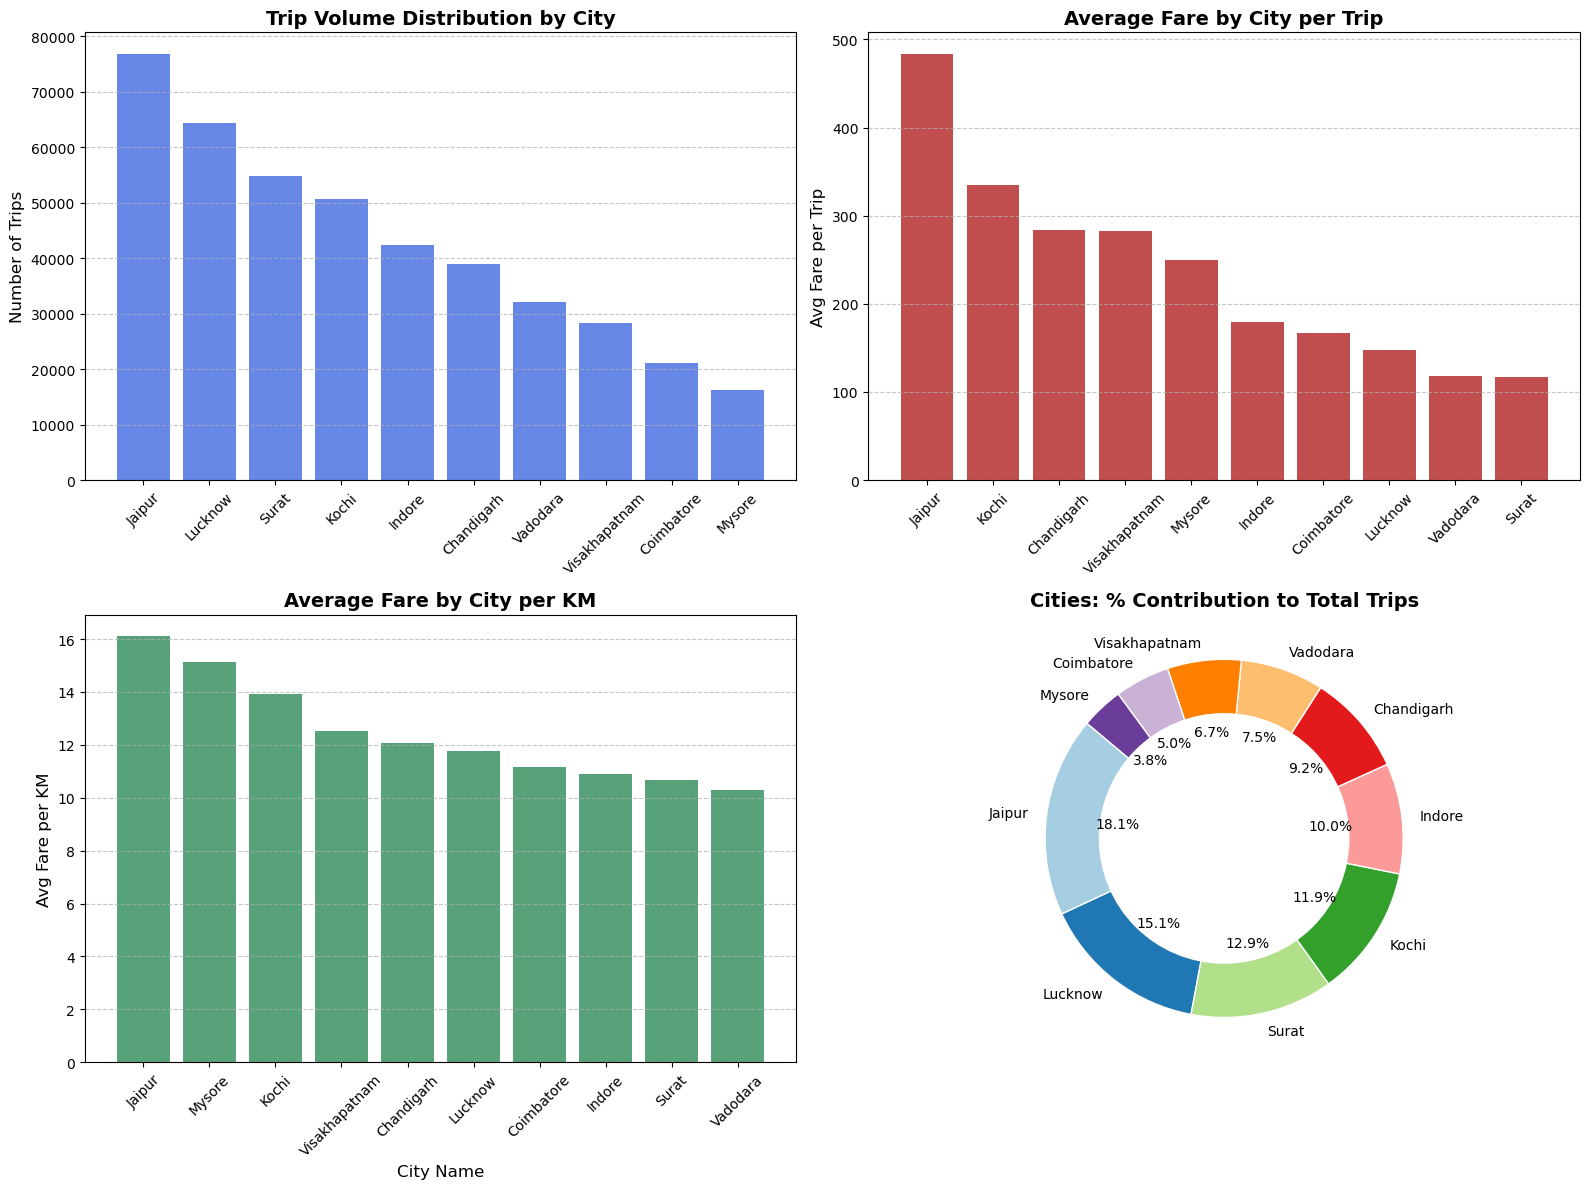

In [151]:
# Extracting relevant columns and sorting values for enchancing visualizations
df_bar_trips = df_adhoc_1[['city_name', 'no_of_trips']].sort_values(by='no_of_trips', ascending=False)
df_bar_fare_trip = df_adhoc_1[['city_name', 'avg_fare_per_trip']].sort_values(by='avg_fare_per_trip', ascending=False)
df_bar_fare_km = df_adhoc_1[['city_name', 'avg_fare_per_km']].sort_values(by='avg_fare_per_km', ascending=False)

# Extracting data for donut chart
df_pie = df_adhoc_1[['city_name', 'pct_contribution_to_total_trips']].sort_values(
    by='pct_contribution_to_total_trips', ascending=False)
# Creating a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ---- Bar Chart 1: Trip Volume ----
axes[0, 0].bar(df_bar_trips['city_name'], df_bar_trips['no_of_trips'], color='royalblue', alpha=0.8)
axes[0, 0].set_ylabel('Number of Trips', fontsize=12)
axes[0, 0].set_title('Trip Volume Distribution by City', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].tick_params(axis='x', rotation=45)

# ---- Bar Chart 2: Average Fare per Trip ----
axes[0, 1].bar(df_bar_fare_trip['city_name'], df_bar_fare_trip['avg_fare_per_trip'], color='firebrick', alpha=0.8)
axes[0, 1].set_ylabel('Avg Fare per Trip', fontsize=12)
axes[0, 1].set_title('Average Fare by City per Trip', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 1].tick_params(axis='x', rotation=45)

# ---- Bar Chart 3: Average Fare per KM ----
axes[1, 0].bar(df_bar_fare_km['city_name'], df_bar_fare_km['avg_fare_per_km'], color='seagreen', alpha=0.8)
axes[1, 0].set_xlabel('City Name', fontsize=12)
axes[1, 0].set_ylabel('Avg Fare per KM', fontsize=12)
axes[1, 0].set_title('Average Fare by City per KM', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 0].tick_params(axis='x', rotation=45)

# ---- Donut Chart: % Contribution to Total Trips ----
wedges, texts, autotexts = axes[1, 1].pie(df_pie['pct_contribution_to_total_trips'], labels=df_pie['city_name'], 
               autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140, wedgeprops={'edgecolor': 'white'})

# Add a center circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')  # Adjust size of hole
axes[1, 1].add_artist(centre_circle)
axes[1, 1].set_title('Cities: % Contribution to Total Trips', fontsize=14, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## **Observations from the Visualizations**

---
**1️⃣ Trip Volume Distribution by City (Top-Left Bar Chart)**

**Objective:** 
Identify which cities have the highest and lowest trip volumes.

**Observations:**
- **Jaipur, Lucknow, and Surat** have the **highest trip volumes**, indicating a **strong demand** for transportation services in these cities.
- **Mysore and Coimbatore have the lowest trip volumes**, suggesting **limited demand or fewer transport services available**.
- **Kochi, Indore, and Chandigarh show moderate trip volumes**, meaning a **balanced market presence** in these cities.

**Actionable Insights:**
✔ **Expand services in Jaipur, Lucknow, and Surat** to **meet growing demand**.  
✔ **Run promotional campaigns in Mysore and Coimbatore** to boost **user adoption**.  

---

**2️⃣ Average Fare per Trip by City (Top-Right Bar Chart)**

**Objective:** 
Compare fare structures across different cities.

**Observations:**
- **Jaipur has the highest average fare per trip (~₹500 per trip)**, indicating **longer average trip distances or premium pricing**.
- **Kochi and Chandigarh also have high fares per trip**, suggesting **higher cost transportation services**.
- **Surat, Lucknow, and Vadodara have the lowest fares per trip**, indicating **shorter trips or competitive market pricing**.

**Actionable Insights:**

✔ **Offer premium ride options in Jaipur, Kochi, and Chandigarh** to attract **higher-paying customers**.  
✔ **Introduce ride-pooling options in Surat, Lucknow, and Vadodara** to **increase profitability** while keeping fares low.  

---

**3️⃣ Average Fare per KM by City (Bottom-Left Bar Chart)**

**Objective:** 
Understand pricing per kilometer across different cities.

**Observations:**
- **Jaipur and Mysore have the highest fare per KM (~₹15-16 per KM)**, making travel **more expensive on a per-KM basis**.
- **Surat, Vadodara, and Indore have the lowest fare per KM (~₹8-9 per KM)**, indicating **affordable transport options**.
- **Kochi and Chandigarh also have relatively high per-KM fares**, aligning with their high **fare per trip** rates.

**Actionable Insights:**

✔ **In high fare per KM cities, introduce incentives for frequent riders** to **increase loyalty**.  
✔ **Optimize surge pricing models in lower fare per KM cities** to **balance affordability and revenue**.  

---

**4️⃣ Percentage Contribution to Total Trips (Bottom-Right Donut Chart)**

**Objective:** 
Identify which cities contribute the most to total trips.

**Observations:**
- **Jaipur contributes the highest to total trips (18.1%)**, followed by **Lucknow (15.1%) and Surat (12.9%)**.
- **Mysore has the lowest contribution (~3.8%)**, highlighting **minimal transport demand**.
- The **top 5 cities account for more than 60% of total trips**, indicating a **highly concentrated market**.

**Actionable Insights:**

✔ **Scale up operations in high-contribution cities (Jaipur, Lucknow, Surat)** by **expanding fleets and increasing driver incentives**.  
✔ **Run awareness campaigns in lower-contribution cities (Mysore, Coimbatore, Visakhapatnam)** to **drive adoption and increase demand**.  

---

---
# Business Request - 2: Monthly City-Level Trips Target Performance Report

Generate a report that evaluates the target performance for trips at the monthly and city level. For each city and month, compare the actual total trips with the target trips.

**Fields:**
- `city_name`
- `month`
- `actual_total_trips`
- `target_total_trips`
- `%_achievement`

In [219]:
query = '''
WITH cte AS (
SELECT
	city_name,
    MONTHNAME(ft.date) AS month,
    COUNT(ft.trip_id) AS total_actual_trips,
    total_target_trips
FROM
	fact_trips ft
JOIN
	dim_city dc
ON
	dc.city_id = ft.city_id
JOIN
	targets_db.monthly_target_trips mtt
ON
	mtt.city_id = ft.city_id AND month(mtt.month) = month(ft.date)
GROUP BY 
	MONTH(ft.date),ft.city_id
)

SELECT 
	*,
    IF(total_actual_trips > total_target_trips , "Above Target" , "Below Target") AS performance_status,
    ROUND(((total_actual_trips - total_target_trips) / total_target_trips) * 100,2) AS "pct_gap_from_target"
FROM
	cte;
'''

df_adhoc_2 = pd.read_sql(query,engine)

df_adhoc_2.head()


,city_name,month,total_actual_trips,total_target_trips,performance_status,pct_gap_from_target
0,Visakhapatnam,January,4468,4500,Below Target,-0.71
1,Chandigarh,January,6810,7000,Below Target,-2.71
2,Surat,January,8358,9000,Below Target,-7.13
3,Vadodara,January,4775,6000,Below Target,-20.42
4,Mysore,January,2485,2000,Above Target,24.25


---
**Understanding the Data Through Visualizations**

To gain a **better understanding** of the data and derive **actionable insights**, we will analyze the **trip performance across cities**, their **deviation from target values**, and overall trends over time. The following visualizations will help us:

📈 **Line Chart** – To examine **trip volume trends** across different cities over the months and identify any increasing or declining patterns.  
📊 **Heatmap** – To visualize the **gap from target (%) for each city per month**, helping us identify **overperforming and underperforming cities**.  

These insights will help in **optimizing transport operations, pricing strategies, and city-specific service improvements**.

---

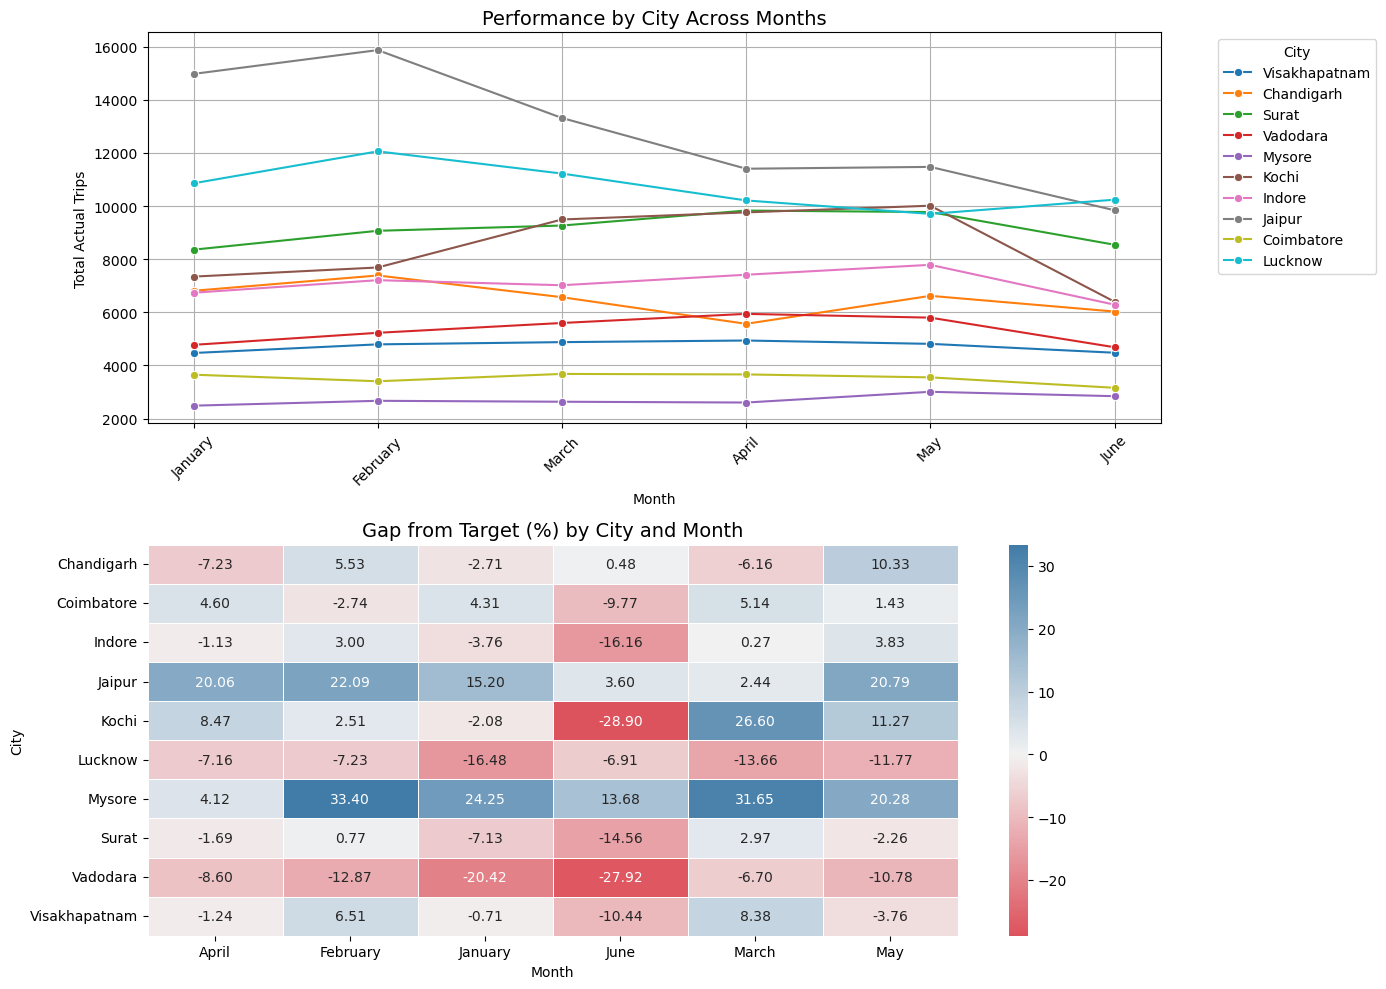

In [202]:
# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# -------- 1. Performance by City Across Months (Line Chart) --------
sns.lineplot(ax=axes[0], data=df_adhoc_2, x="month", y="total_actual_trips", hue="city_name", marker="o")
axes[0].set_title("Performance by City Across Months", fontsize=14)
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Total Actual Trips")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# -------- 2. Gap from Target (%) by City and Month (Heatmap) --------
pivot_table = df_adhoc_2.pivot(index="city_name", columns="month", values="pct_gap_from_target")

# Define color palette (green for positive, red for negative)
cmap = sns.diverging_palette(10,240, as_cmap=True)

sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", linewidths=0.5, center=0, ax=axes[1])
axes[1].set_title("Gap from Target (%) by City and Month", fontsize=14)
axes[1].set_xlabel("Month")
axes[1].set_ylabel("City")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---
#### **Observations from the Visualization**

**1️⃣ Performance by City Across Months (Line Chart - Top)**

**Objective:** 
Analyze trends in trip volume across cities over six months.

**Observations:**
- **Jaipur** had the **highest number of trips initially** but saw a **declining trend from March onwards**.
- **Lucknow** maintained a **steady increase in trip volume**, indicating **consistent market growth**.
- **Surat, Indore, and Kochi** displayed **stable trends**, suggesting **consistent demand** without major fluctuations.
- **Mysore and Coimbatore had the lowest number of trips**, indicating **low market penetration** or **limited transport demand**.

**Actionable Insights:**
 
✔ **Lucknow’s success model should be replicated** in cities with similar demographics.  
✔ **Mysore and Coimbatore require marketing campaigns and incentives** to boost adoption. 

---
**2️⃣ Gap from Target (%) by City and Month (Heatmap - Bottom)**

**Objective:** 
Evaluate how cities performed relative to their **target trip goals**.

**Observations:**
- **Mysore significantly exceeded trip targets** in **February (+33.40%) and March (+31.65%)**, indicating **high demand**.
- **Jaipur consistently outperformed expectations**, with **+20.06% in April, +22.09% in February, and +20.79% in May**.
- **Kochi showed a major decline in June (-28.90%)**, meaning it performed significantly below expected levels.
- **Vadodara had the highest negative deviation (-27.92%) in June**, indicating challenges in meeting demand.

### **Actionable Insights:**
✔ **Sustain growth in Mysore and Jaipur** by implementing **customer retention strategies** like **loyalty programs**.  
✔ **Investigate the decline in Kochi and Vadodara** – to regain lost demand.  
✔ **Align marketing strategies with peak-performing months** to maximize engagement and revenue.  

---

# **Business Request - 3**: City-Level Repeat Passenger Trip Frequency Report

Generate a report that shows the percentage distribution of repeat passengers by the number of trips they have taken in each city. Calculate the percentage of repeat passengers who took 2 trips, 3 trips, and so on, up to 10 trips.

Each column should represent a trip count category, displaying the percentage of repeat passengers who fall into that category out of the total repeat passengers for that city.

This report will help identify cities with high repeat trip frequency, which can indicate strong customer loyalty or frequent usage patterns.

## **Fields:**
- `city_name`
- `2-Trips`
- `3-Trips`
- `4-Trips`
- `5-Trips`
- `6-Trips`
- `7-Trips`
- `8-Trips`
- `9-Trips`
- `10-Trips`

In [239]:
query = '''
WITH cte AS (
	SELECT 
		city_id,
        city_name,
		trip_count,
		ROUND((repeat_passenger_count / SUM(repeat_passenger_count) over(partition by city_id))*100,2) AS pct_repeat_passenger_by_category
	FROM
		dim_repeat_trip_distribution
	JOIN 
		dim_city
	USING
		(city_id)
	GROUP BY
		city_id , trip_count
)
SELECT
	city_name,
    SUM(IF(trip_count = '2-Trips',  pct_repeat_passenger_by_category, 0)) AS `2-Trips`,
    SUM(IF(trip_count = '3-Trips',  pct_repeat_passenger_by_category, 0)) AS `3-Trips`,
    SUM(IF(trip_count = '4-Trips',  pct_repeat_passenger_by_category, 0)) AS `4-Trips`,
    SUM(IF(trip_count = '5-Trips',  pct_repeat_passenger_by_category, 0)) AS `5-Trips`,
    SUM(IF(trip_count = '6-Trips',  pct_repeat_passenger_by_category, 0)) AS `6-Trips`,
    SUM(IF(trip_count = '7-Trips',  pct_repeat_passenger_by_category, 0)) AS `7-Trips`,
    SUM(IF(trip_count = '8-Trips',  pct_repeat_passenger_by_category, 0)) AS `8-Trips`,
    SUM(IF(trip_count = '9-Trips',  pct_repeat_passenger_by_category, 0)) AS `9-Trips`,
    SUM(IF(trip_count = '10-Trips', pct_repeat_passenger_by_category, 0)) AS `10-Trips`
FROM
	cte
GROUP BY
	city_id
'''

df_adhoc_3 = pd.read_sql(query,engine)

df_adhoc_3

,city_name,2-Trips,3-Trips,4-Trips,5-Trips,6-Trips,7-Trips,8-Trips,9-Trips,10-Trips
0,Visakhapatnam,54.15,24.31,8.15,5.85,2.15,1.54,1.69,1.08,1.08
1,Chandigarh,27.22,25.28,12.08,16.53,6.11,4.58,4.31,1.94,1.94
2,Surat,7.69,13.60,15.29,30.91,14.53,9.04,4.65,2.03,2.28
3,Vadodara,7.54,17.83,17.28,20.04,18.01,11.76,3.86,2.21,1.47
4,Mysore,43.60,31.40,12.79,5.81,2.91,1.16,1.74,0.00,0.58
5,Kochi,51.57,23.65,7.30,7.80,4.15,2.14,1.64,1.01,0.75
6,Indore,38.63,18.78,11.62,11.62,7.65,5.23,3.29,1.94,1.26
7,Jaipur,49.58,19.55,13.64,8.30,2.46,3.02,1.55,0.98,0.91
8,Coimbatore,12.50,17.60,16.33,24.74,13.78,6.38,5.87,2.55,0.26
9,Lucknow,5.38,14.12,14.05,24.60,22.71,9.57,6.08,2.52,0.98


---
### **Understanding the Heatmap of Trips Across Cities**

To gain a **better understanding** of trip distribution patterns across different cities and trip categories, we will analyze the **heatmap visualization**. This heatmap provides insights into:

📊 **Trip Frequency** – How often different cities fall into various trip categories.  
🔍 **High & Low Density Areas** – Identifying cities with high trip counts and cities with lower trip occurrences.  
📌 **Trip Patterns Across Cities** – Understanding which cities have a diverse spread across trip categories and which have concentrated trip patterns. 

---

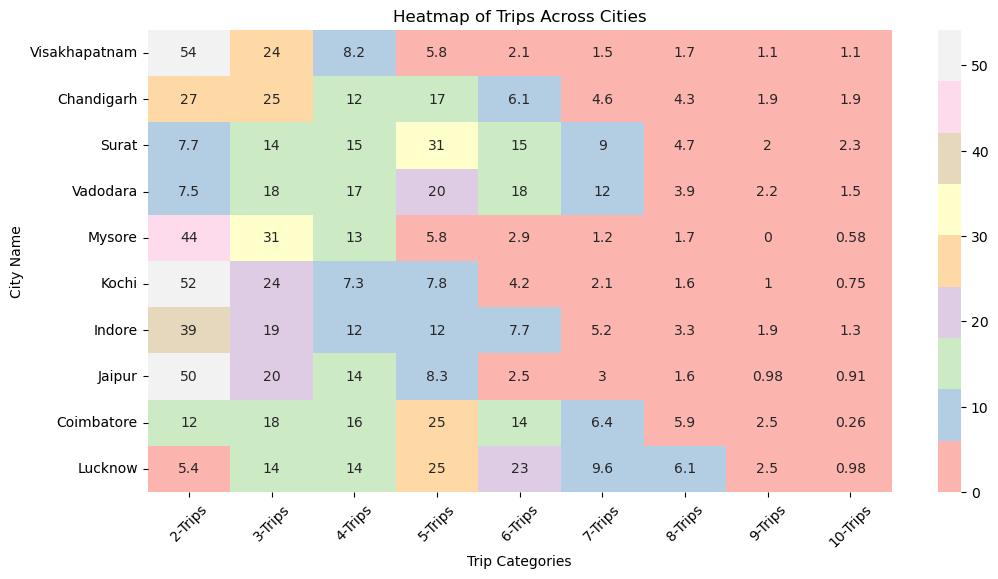

In [386]:
plt.figure(figsize=(12, 6))
# Define color palette 

sns.heatmap(df_adhoc_3.iloc[:, 1:], annot=True, cmap='Pastel1',xticklabels=df_adhoc_3.columns[1:], yticklabels=df_adhoc_3["city_name"])
plt.xlabel("Trip Categories")
plt.ylabel("City Name")
plt.title("Heatmap of Trips Across Cities")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

---
### **Key Insights:**
- **Visakhapatnam, Kochi, Mysore, and Jaipur** have **high counts in lower trip categories (2-Trips, 3-Trips)**, indicating frequent shorter trips.
- **Surat and Vadodara** have **higher counts in the mid-range trip categories (4-Trips, 5-Trips)**, suggesting moderate trip frequency.
- **Coimbatore and Lucknow** show a **more even distribution across trip categories**, indicating **a well-balanced range of trip frequencies**.
- **Some cities have very low trip counts in higher trip categories (9-Trips, 10-Trips)**, meaning extended trips are less common.
---

# **Business Request - 4**: Identify Cities with Highest and Lowest Total New Passengers

Generate a report that calculates the total new passengers for each city and ranks them based on this value. 

Identify the top 3 cities with the highest number of new passengers as well as the bottom 3 cities with the lowest number of new passengers, categorizing them as "Top 3" or "Bottom 3" accordingly.

### **Fields:**
- `city_name`
- `total_new_passengers`
- `city_category` ("Top 3" or "Bottom 3")

In [294]:
query = '''
WITH cte AS (
	SELECT
		city_id,
		SUM(new_passengers) AS total_new_passengers,
		CASE
			WHEN RANK() OVER(ORDER BY SUM(new_passengers) DESC ) <= 3 THEN "Top 3"
			WHEN RANK() OVER(ORDER BY SUM(new_passengers) DESC ) >= 8 THEN "Bottom 3"
		ELSE
			"-"
		END AS city_category
	FROM
		fact_passenger_summary
	GROUP BY
		city_id
)
SELECT
	city_name,
    total_new_passengers,
    city_category
FROM
	cte
JOIN 
	dim_city
USING
	(city_id)
WHERE
	city_category NOT IN("-")
ORDER BY
    total_new_passengers DESC
'''
df_adhoc_4 = pd.read_sql(query,engine)

df_adhoc_4

,city_name,total_new_passengers,city_category
0,Jaipur,45856.0,Top 3
1,Kochi,26416.0,Top 3
2,Chandigarh,18908.0,Top 3
3,Surat,11626.0,Bottom 3
4,Vadodara,10127.0,Bottom 3
5,Coimbatore,8514.0,Bottom 3


----
### **Understanding the Growth of New Passengers Across Cities**

To gain a **better understanding** of new passenger growth and market adoption, we will analyze the **total number of new passengers across cities**. The following visualization helps us identify **which cities are leading in new passenger acquisition** and which cities are **lagging behind**, providing insights for strategic planning.

📊 **Bar Chart** – Highlights the **top 3 cities with the highest number of new passengers** and the **bottom 3 cities with the lowest number of new passengers**.  
📌 **Green Bars** – Represent the **top-performing cities** in terms of new passenger growth.  
📌 **Red Bars** – Represent the **cities struggling with low new passenger adoption**. 

---

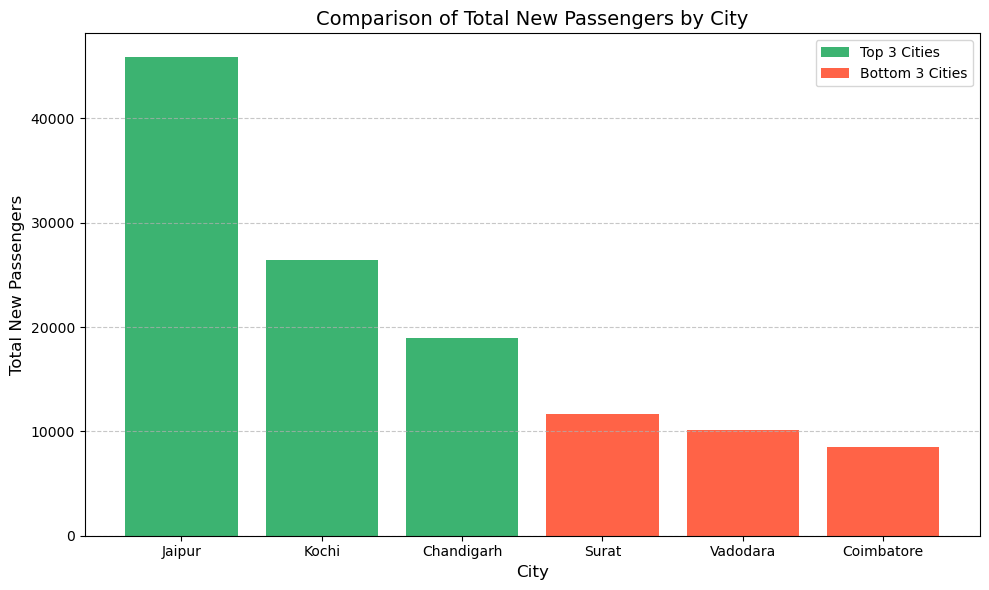

In [414]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors based on category
colors = ["mediumseagreen" if category == "Top 3" else "tomato" for category in df_adhoc_4["city_category"]]

# Create the bar chart
ax.bar(df_adhoc_4["city_name"], df_adhoc_4["total_new_passengers"], color=colors)

# Labels and Title
ax.set_title("Comparison of Total New Passengers by City", fontsize=14)
ax.set_ylabel("Total New Passengers", fontsize=12)
ax.set_xlabel("City", fontsize=12)

# Legend
top3_patch = plt.Rectangle((0,0),1,1,fc="mediumseagreen", label="Top 3 Cities")
bottom3_patch = plt.Rectangle((0,0),1,1,fc="tomato", label="Bottom 3 Cities")
ax.legend(handles=[top3_patch, bottom3_patch], loc="upper right")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

---
### **Key Insights:**
- **Jaipur has the highest number of new passengers**, significantly outpacing other cities, suggesting **high demand and strong transport adoption**.
- **Kochi and Chandigarh also perform well**, indicating **growing markets** with potential for further expansion.
- **Surat, Vadodara, and Coimbatore lag behind**, suggesting **limited service reach, lower commuter demand, or lack of awareness**.

### **Actionable Strategies:**
✔ **For high-growth cities (Jaipur, Kochi, Chandigarh)** – Introduce **loyalty programs** and **premium ride options** to **retain and monetize the growing user base**.  
✔ **For low-growth cities (Surat, Vadodara, Coimbatore)** – Implement **targeted marketing campaigns anfirst-ride discounts to**increase adoption**.  

---

# **Business Request - 5**: Identify Month with Highest Revenue for Each City

Generate a report that identifies the month with the highest revenue for each city. 

For each city, display the `month_name`, the revenue amount for that month, and the percentage contribution of that month’s revenue to the city’s total revenue.

## **Fields:**
- `city_name`
- `highest_revenue_month`
- `revenue`
- `percentage_contribution (%)`

In [346]:
query = '''
WITH cte AS(

	SELECT
		city_id,
		MONTHNAME(date) As month,
		SUM(fare_amount) AS revenue
	FROM
		fact_trips
	GROUP BY
		MONTH(date),city_id
),
cte_1 AS(
	SELECT
		city_name,
		month,
		revenue,
		RANK() OVER (PARTITION BY city_id ORDER BY revenue DESC) AS rnk,
		ROUND((revenue/SUM(revenue) OVER(PARTITION BY city_id))*100,2) AS percentage_contribution_month_revenue_city_total_revenue
	FROM 
		cte
	JOIN
		dim_city
	USING
		(city_id)
)
SELECT
	city_name,
    month,
    revenue,
    percentage_contribution_month_revenue_city_total_revenue
FROM
	cte_1
WHERE
	rnk = 1
'''
df_adhoc_5 = pd.read_sql(query,engine)

df_adhoc_5

,city_name,month,revenue,percentage_contribution_month_revenue_city_total_revenue
0,Visakhapatnam,April,1390682.0,17.34
1,Chandigarh,February,2108290.0,19.07
2,Surat,April,1154909.0,17.96
3,Vadodara,April,706250.0,18.60
4,Mysore,May,745170.0,18.38
5,Kochi,May,3333746.0,19.61
6,Indore,May,1380996.0,18.09
7,Jaipur,February,7747202.0,20.82
8,Coimbatore,April,612431.0,17.38
9,Lucknow,February,1777269.0,18.78


----

---

### **Understanding the Highest Revenue Month for Each City**

To gain **better insights into revenue trends** across different cities, this visualization highlights the **month in which each city generated its highest revenue**. Understanding these peak months helps in **strategic planning, forecasting, and optimizing promotional campaigns**.

📊 **Bar Chart** – Represents the **percentage contribution of the highest revenue month** to the city's total revenue.  
📅 **Month Labels** – Indicate **which month had the highest revenue** for each city.  

---

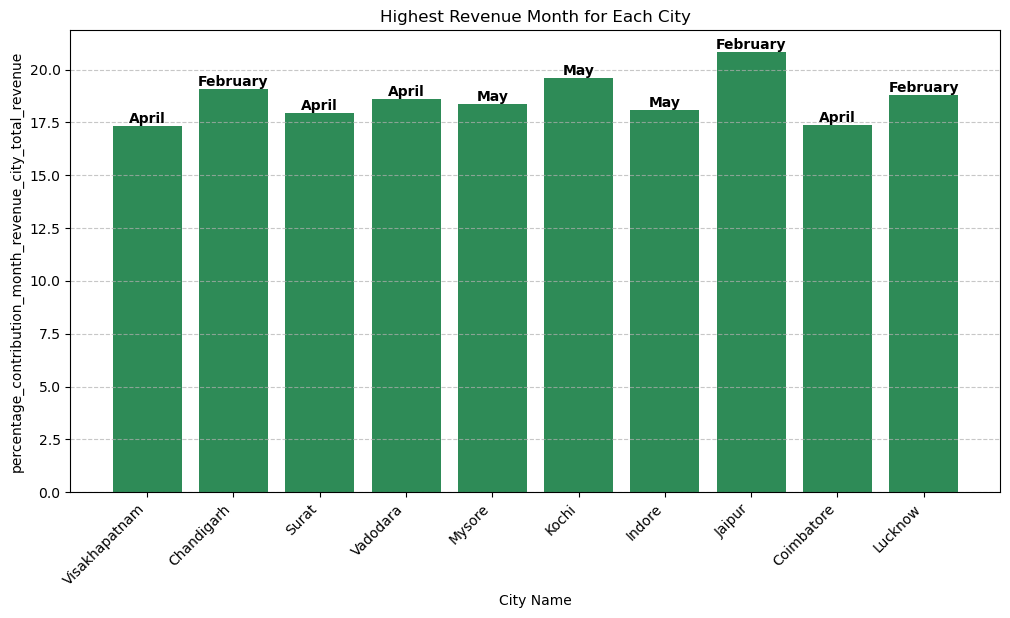

In [375]:
# Plotting the Grouped Bar Chart
plt.figure(figsize=(12, 6))
bars = plt.bar(df_adhoc_5["city_name"], df_adhoc_5["percentage_contribution_month_revenue_city_total_revenue"], color='seagreen')

# Adding annotations for percentage contribution + Month
for bar,month in zip(bars,df_adhoc_5["month"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f"{month}",  # Adding the month in the label
             ha='center', va='bottom', fontsize=10, fontweight='bold')


# Labels and title
plt.xlabel("City Name")
plt.ylabel("percentage_contribution_month_revenue_city_total_revenue")
plt.title("Highest Revenue Month for Each City")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show the plot
plt.show()

---
### **Key Insights:**
- **February was the highest revenue month for Indore, Lucknow, and Jaipur**, indicating **strong demand during this period**.
- **May was the peak revenue month for Kochi,Indore and Mysore**, suggesting **a possible seasonal effect or increased travel activity**.
- **April generated the highest revenue for Visakhapatnam, Surat, Chandigarh, and Coimbatore**, showing **a revenue boost in Q2**.

### **Actionable Strategies:**
✔ **For peak months in each city**, increase **marketing efforts and service availability** to maximize revenue potential.  
✔ **For months with lower revenue**, introduce **seasonal discounts or promotional offers** to **boost demand during slow periods**.  

---

# **Business Request - 6**: Repeat Passenger Rate Analysis

Generate a report that calculates two metrics:

1. **Monthly Repeat Passenger Rate**: Calculate the repeat passenger rate for each city and month by comparing the number of repeat passengers to the total passengers.
2. **City-wide Repeat Passenger Rate**: Calculate the overall repeat passenger rate for each city, considering all passengers across months.

These metrics will provide insights into monthly repeat trends as well as the overall repeat behavior for each city.

### **Fields:**
- `city_name`
- `month`
- `total_passengers`
- `repeat_passengers`
- `monthly_repeat_passenger_rate (%)`: Repeat passenger rate at the city and month level
- `city_repeat_passenger_rate (%)`: Overall repeat passenger rate for each city, aggregated across months

In [388]:
query = '''
SELECT
	city_name,
    MONTHNAME(month) AS month,
    total_passengers,
    repeat_passengers,
    ROUND((repeat_passengers/total_passengers)* 100,2) AS monthly_repeat_passengers_rate_pct,
    ROUND((SUM(repeat_passengers) OVER(PARTITION BY city_id)/SUM(total_passengers) OVER(PARTITION BY city_id))*100,2) AS city_repeat_passenger_rate_pct
FROM
	fact_passenger_summary
JOIN 
	dim_city
USING
	(city_id)
ORDER BY
	city_name,month(month)
'''
df_adhoc_6 = pd.read_sql(query,engine)

df_adhoc_6.head(10)

,city_name,month,total_passengers,repeat_passengers,monthly_repeat_passengers_rate_pct,city_repeat_passenger_rate_pct
0,Chandigarh,January,4640,720,15.52,21.14
1,Chandigarh,February,4957,853,17.21,21.14
2,Chandigarh,March,4100,872,21.27,21.14
3,Chandigarh,April,3285,789,24.02,21.14
4,Chandigarh,May,3699,969,26.20,21.14
5,Chandigarh,June,3297,867,26.30,21.14
6,Coimbatore,January,2214,392,17.71,23.05
7,Coimbatore,February,1993,346,17.36,23.05
8,Coimbatore,March,1965,427,21.73,23.05
9,Coimbatore,April,1722,480,27.87,23.05


---

### Data Visualization for Repeat Passenger Analysis

To gain a better understanding of the data and draw actionable insights, we will visualize the **repeat passenger trends** and **city-level contribution rates**. The following charts will help us:

📊 **Bar Chart** – To analyze the **repeat passenger rate across cities**, highlighting cities with the highest and lowest retention.  

📊 **Line Charts** – To track **monthly trends in total passengers, repeat passengers, and repeat passenger rate** across cities, helping identify seasonal patterns and city-wise performance.  

---

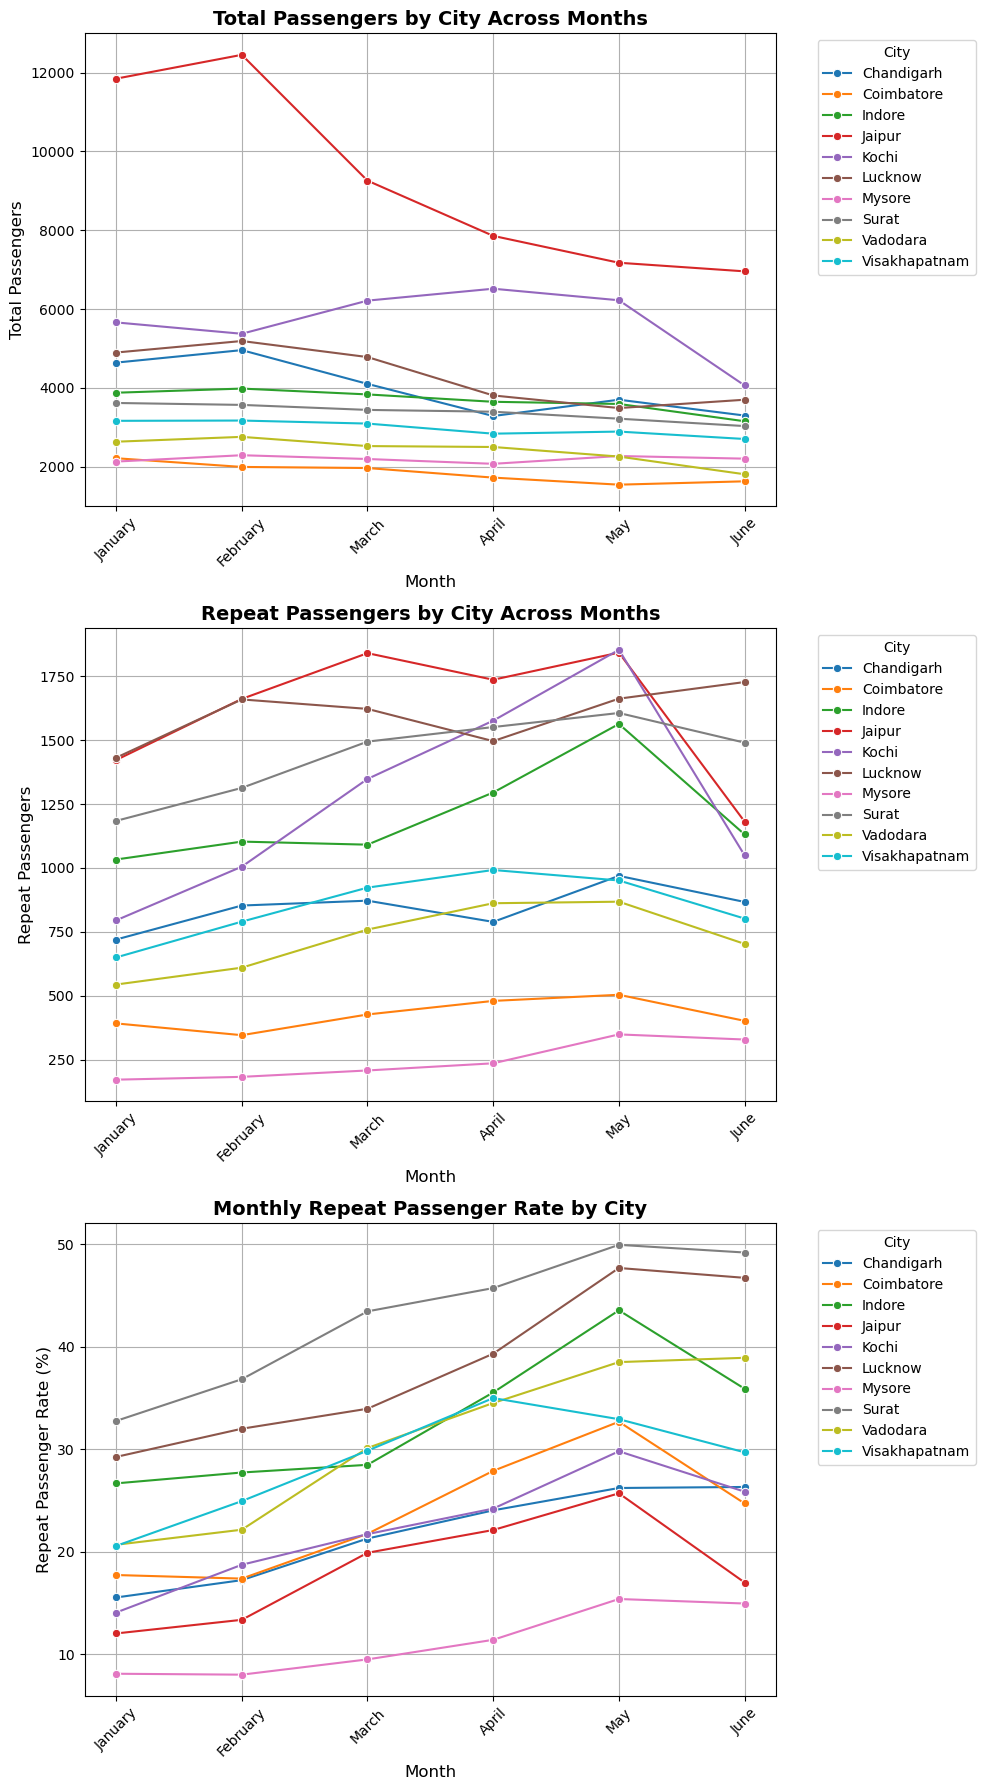

In [418]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# First subplot: Total Passengers Over Time
sns.lineplot(ax=axes[0], data=df_adhoc_6, x="month", y="total_passengers", hue="city_name", marker="o")
axes[0].set_title("Total Passengers by City Across Months", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Month", fontsize=12)
axes[0].set_ylabel("Total Passengers", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# Second subplot: Repeat Passengers Over Time
sns.lineplot(ax=axes[1], data=df_adhoc_6, x="month", y="repeat_passengers", hue="city_name", marker="o")
axes[1].set_title("Repeat Passengers by City Across Months", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Month", fontsize=12)
axes[1].set_ylabel("Repeat Passengers", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

# Third subplot: Repeat Passenger Rate Over Time
sns.lineplot(ax=axes[2], data=df_adhoc_6, x="month", y="monthly_repeat_passengers_rate_pct", hue="city_name", marker="o")
axes[2].set_title("Monthly Repeat Passenger Rate by City", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Month", fontsize=12)
axes[2].set_ylabel("Repeat Passenger Rate (%)", fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

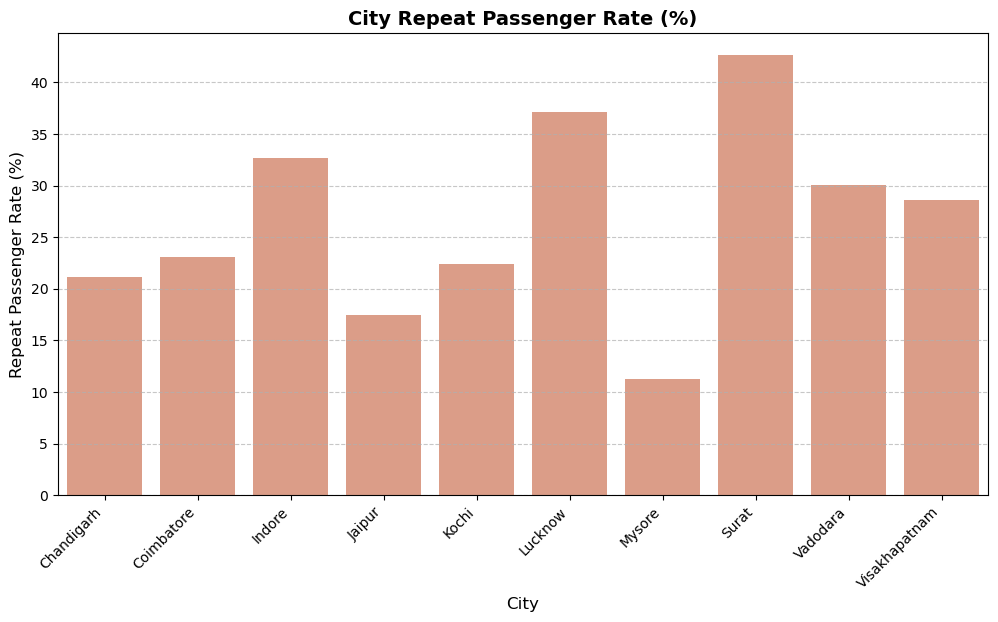

In [416]:
# Creating a bar plot for city repeat passenger rate percentage
plt.figure(figsize=(12, 6))
sns.barplot(data=df_adhoc_6, x="city_name", y="city_repeat_passenger_rate_pct", color='darksalmon')

# Titles and labels
plt.title("City Repeat Passenger Rate (%)", fontsize=14, fontweight='bold')
plt.xlabel("City", fontsize=12)
plt.ylabel("Repeat Passenger Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

---

### **Key Insights from Data Visualizations**

**1️⃣ Total Passengers by City Across Months (Line Chart)**
- **Cities like Jaipur and Lucknow consistently have higher passenger volumes**, indicating **strong travel demand and potential for further business expansion**.  
- **Cities like Coimbatore and Mysore have relatively lower passenger counts**, suggesting **opportunities to increase ridership through targeted promotions**.  
- **Passenger volume tends to drop in June across most cities**, possibly due to seasonal travel patterns or external factors affecting demand.

**2️⃣ Repeat Passengers by City Across Months (Line Chart)**
- **Lucknow and Surat lead in repeat passenger volume**, reflecting **high customer loyalty and strong retention strategies**.  
- **Mysore has the lowest repeat passengers**, highlighting **a potential gap in customer engagement or satisfaction**.  
- **Repeat passengers tend to peak around May and June in several cities**, suggesting **a trend of returning customers during this period**.  

**3️⃣ Monthly Repeat Passenger Rate by City (Line Chart)**
- **Surat has the highest repeat passenger rate (~50%)**, meaning **almost half of its travelers return regularly**, making it an **ideal city for loyalty-based marketing**.  
- **Mysore has the lowest repeat passenger rate (~10%)**, indicating **a need for strategies to improve customer retention**.  
- **Repeat passenger rates increase steadily from January to June in most cities**, suggesting **a growing trend in repeat travelers over time**.  


**4️⃣ City Repeat Passenger Rate (%) (Bar Chart)**
- **Surat, Lucknow, and Indore have the highest repeat passenger rates**, making them **strong candidates for subscription models, membership benefits, or premium services**.  
- **Mysore has the lowest repeat passenger rate**, indicating **a need to investigate service quality, pricing, or competition in the area**.  
- **Most cities maintain a repeat passenger rate above 20%,** signaling **a healthy level of customer retention overall**.

---


 ## ------------------------------------- 🔚 **End of Document** ----------------------------------